# Visualize similar poses across age according to the model

In [15]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
from itertools import repeat
from toolz import groupby, topk
from sklearn.cluster import k_means
from toolz.curried import get, pluck
from sklearn.decomposition import PCA
from scipy.spatial.distance import cdist
from aging.organization.dataframes import get_age
from aging.organization.paths import get_experiments_grouped_by_age
from aging.plotting import format_plots, PLOT_CONFIG, save_factory, figure

In [11]:
format_plots()
saver = save_factory(PLOT_CONFIG.save_path / 'fig1', tight_layout=False)

In [8]:
groups = get_experiments_grouped_by_age(old=True)['ontogeny_males']

## Get pose "classes" from 3 month old mice

In [13]:
frames_per_sample = 750
files_3m = groups[12]
frames_key = 'win_size_norm_frames_v7'

np.random.seed(0)

frames = []
for file in tqdm(files_3m):
    try:
        with h5py.File(file, 'r') as h5f:
            indices = np.sort(np.random.permutation(len(h5f[frames_key]))[:frames_per_sample])
            data = h5f[frames_key][indices].astype('uint8')
            frames.append(data)

    except KeyError:
        continue

frames = np.concatenate(frames, axis=0)

  0%|          | 0/16 [00:00<?, ?it/s]

In [16]:
pca = PCA(n_components=10)
pcs = pca.fit_transform(frames.reshape(len(frames), -1))

In [17]:
pcs.shape

(12000, 10)

In [18]:
centroid, labels, inertia = k_means(pcs, n_clusters=14, random_state=0)

In [19]:
labels

array([ 0,  8,  2, ...,  2, 13,  5], dtype=int32)

In [20]:
np.bincount(labels)

array([1397,  248, 2536, 1264,  350,  281,  808,  383, 2550,  864,  210,
        216,  340,  553])

/home/wg41/miniconda3/envs/aging/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/wg41/miniconda3/envs/aging/lib/python3.10/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


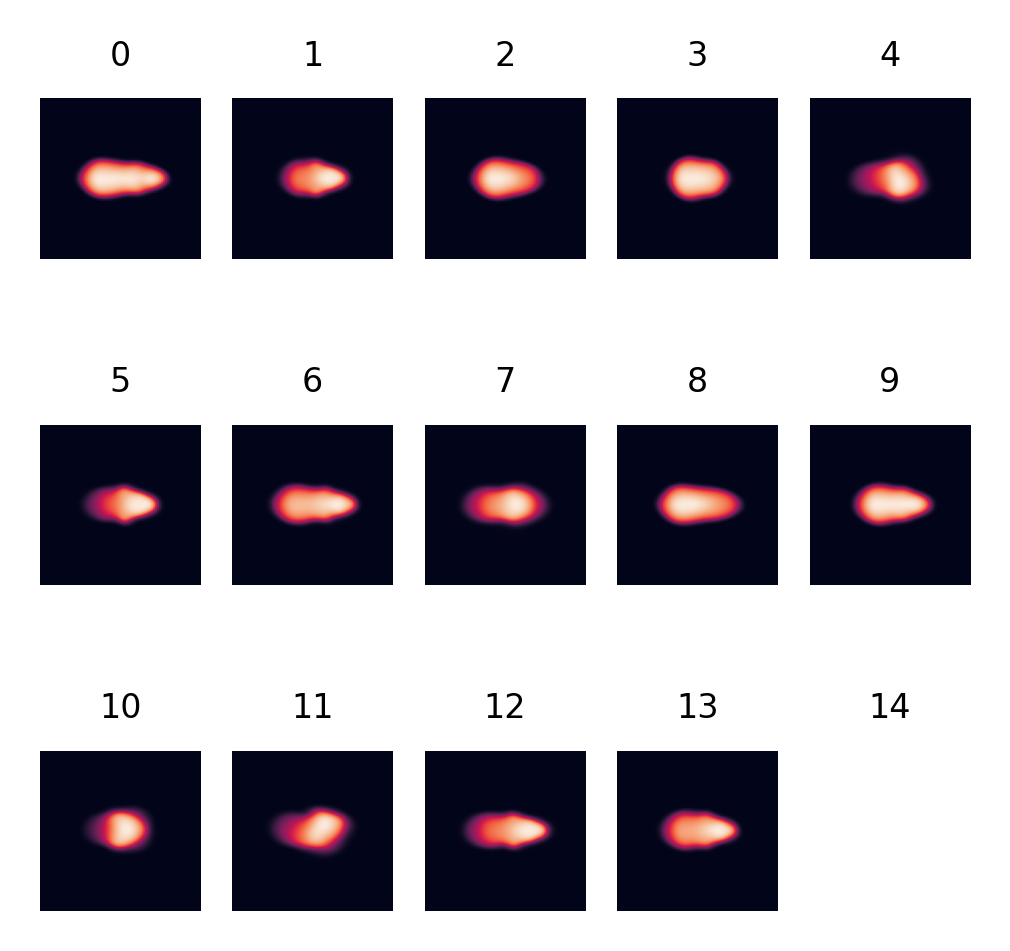

In [21]:
fig, ax = plt.subplots(3, 5)
for i, a in enumerate(ax.flat):
    a.imshow(np.mean(frames[labels == i], axis=0))
    a.set_title(i)
    a.set_axis_off()

- find most similar 3mo old animal to centroid
- then go through ages, find most similar animal to 3mo old in each age group

In [22]:
label_list = [0, 3, 7]

templates = {}
for label in label_list:
    examples = pcs[labels == label]
    topk_idx = cdist(examples, centroid[[label]]).squeeze().argmin()
    templates[label] = examples[topk_idx]

In [23]:
templates

{0: array([ -83.65859308, -145.34108419,   29.20639419,   19.80649836,
          -7.49074524,    9.60125437,   21.886877  ,    9.33120844,
          20.92938046,   -8.91654715]),
 3: array([ -7.97193553, 173.31145728,  -9.79736029,   7.76342965,
         -0.8482204 ,  30.94107493, -19.98255032,  20.219366  ,
         22.75063216,   3.11461285]),
 7: array([ 2.82004993e+02, -1.93001880e+01,  4.80799011e+01, -2.50427232e+01,
        -3.43861077e+01, -1.79317447e-01,  3.21699047e+01, -3.76837408e-01,
         1.59862893e+01,  1.93659276e+01])}

In [24]:
n_frames = 12_500

pc_dict = {}
for age, _files in tqdm(groups.items()):
    frames = {}
    for file in _files:
        with h5py.File(file, 'r') as h5f:
            data = h5f[frames_key][:n_frames].astype('uint8')
            frames[file] = pca.transform(data.reshape(len(data), -1))
    pc_dict[age] = frames

  0%|          | 0/23 [00:00<?, ?it/s]

In [25]:
n_best = 10
examples = {}
for age, frames in pc_dict.items():
    for lbl, template in templates.items():
        best_examples = []
        best_dist = np.inf
        for file, _frames in frames.items():
            dist = cdist(_frames, [template]).squeeze()
            topk_idx = dist.argmin()
            best = list(topk(n_best, zip(enumerate(repeat(file)), -dist), key=get(1)))
            best_examples.extend(best)
        examples[(age, lbl)] = list(pluck(0, topk(n_best, best_examples, key=get(1))))

In [26]:
def get_frame(idx, file):
    with h5py.File(file, 'r') as h5f:
        return (h5f[frames_key][idx].astype('uint8'), h5f['frames'][idx].astype('uint8'))

In [27]:
# loop through examples and load frames + reconstructions
example_frames = {}
for key, _topk in tqdm(examples.items()):
    example_frames[key] = [get_frame(*args) for args in _topk]

In [40]:
def week_translator(key):
    if 'm' in key:
        return int(key.replace('m', '')) * 4
    elif 'w' in key:
        return int(key.replace('w', ''))

In [28]:
keys = list(example_frames)

In [30]:
keys = list(example_frames)
sorted_keys = sorted(sorted(keys, key=lambda x: x[0]), key=lambda x: x[1])
grouped_keys = groupby(get(1), sorted_keys)

In [32]:
grouped_keys[0]

[(4, 0),
 (8, 0),
 (12, 0),
 (16, 0),
 (20, 0),
 (24, 0),
 (28, 0),
 (32, 0),
 (36, 0),
 (40, 0),
 (44, 0),
 (48, 0),
 (52, 0),
 (56, 0),
 (60, 0),
 (64, 0),
 (68, 0),
 (72, 0),
 (78, 0),
 (80, 0),
 (84, 0),
 (90, 0),
 (103, 0)]

In [ ]:
# slice into image, selecting only pose pixels
rows = slice(30, -30)
cols = slice(10, -10)

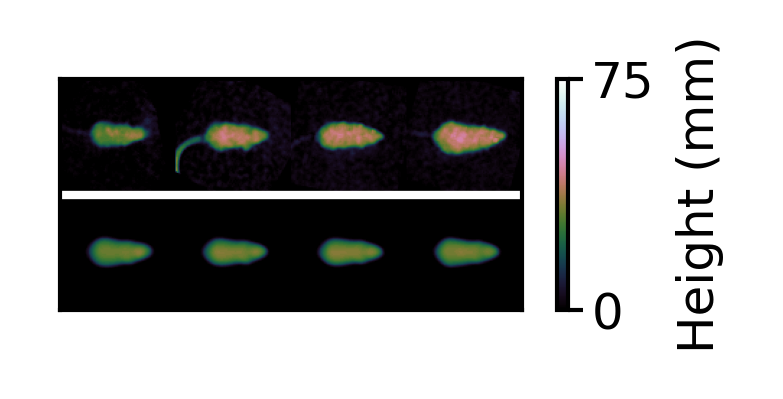

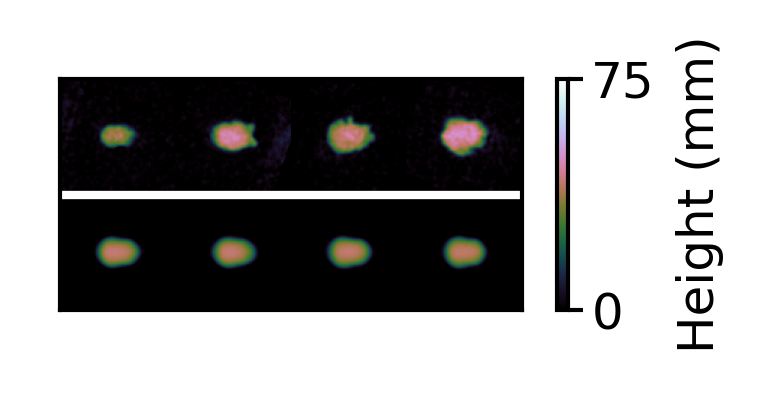

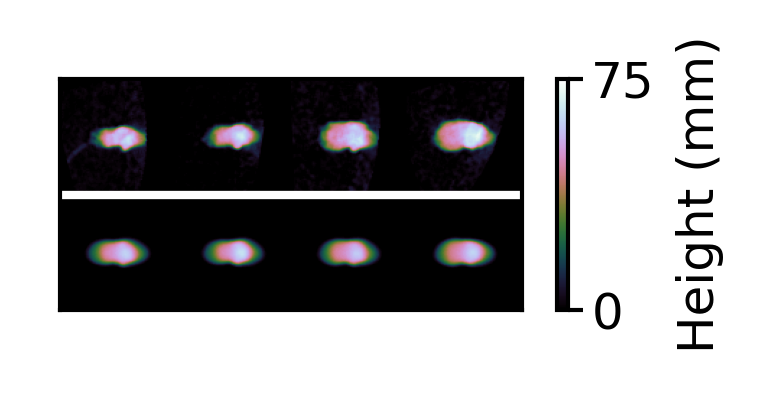

In [48]:
# topk_idx = 9
inds = [0, 2, 20]
for (lbl, _keys), topk_idx in zip(grouped_keys.items(), [1, 9, 1]):
    concat = np.concatenate([example_frames[_keys[key]][topk_idx][0] for key in inds], axis=1)
    concat2 = np.concatenate([example_frames[_keys[key]][topk_idx][1] for key in inds], axis=1)
    concat = np.concatenate([concat2, concat], axis=0)
    fig = figure(1.5, 0.5)
    plt.imshow(concat, cmap='cubehelix', vmax=75)
    plt.axhline(80, color='w', lw=1)
    cb = plt.colorbar(label='Height (mm)')
    cb.set_ticks([0, 75])
    plt.xticks([])
    plt.yticks([])
    saver(fig, f'same-pose-across-age-{lbl}');

In [49]:
[_keys[i] for i in inds]

[(4, 7), (12, 7), (44, 7), (84, 7)]